<a href="https://colab.research.google.com/github/insistedMarin/ML-based-Recommendation-Systems/blob/main/Matrix_Factorization_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls

drive  sample_data


In [3]:
!cd drive/MyDrive/research/

In [4]:
import tensorflow as tf
import pandas as pd

In [5]:
from matplotlib import pyplot as plt

In [6]:
file = pd.read_csv('/content/drive/MyDrive/research/user_item_matrix_1.csv')

In [7]:
rating_df=file[:100000:]

In [8]:
user_count=rating_df[['session']].nunique()
item_count=rating_df[['aid']].nunique()
print(user_count)
print(item_count)
dict_users=rating_df['session'].unique()
dict_users = dict_users.tolist()
len(dict_users)

session    2302
dtype: int64
aid    73139
dtype: int64


2302

In [9]:
dict_items=rating_df['aid'].unique()
len(dict_items)

73139

In [10]:
dict_items = dict_items.tolist()
index = list(range(len(dict_items)))
dict_items_to_index=dict(zip(dict_items,index))
def encode_aid(x):
    return dict_items_to_index[x]


rating_df['aid']=rating_df['aid'].map(encode_aid)
rating_df.head(10)

<ipython-input-10-0aaae983a3e6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df['aid']=rating_df['aid'].map(encode_aid)


,Unnamed: 0,session,aid,type
0,0,0,0,1
1,1,0,1,2
2,2,0,2,1
3,3,0,3,1
4,4,0,4,1
5,5,0,5,1
6,6,0,6,1
7,7,0,7,1
8,8,0,8,2
9,9,0,9,1


In [11]:
def build_rating_sparse_tensor(ratings_df):
  indices = ratings_df[['session', 'aid']].values
  values = ratings_df['type'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[int(user_count), int(item_count)])

In [12]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, item_embeddings):
  predictions = tf.gather_nd(
      tf.matmul(user_embeddings, item_embeddings, transpose_b=True),
      sparse_ratings.indices)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss
# def sparse_mean_square_error(sparse_ratings, user_embeddings, item_embeddings):
#   predictions = tf.reduce_sum(
#       tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
#       tf.gather(item_embeddings, sparse_ratings.indices[:, 1]),
#       axis=1)
#   loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
#   return loss

In [98]:
import collections


class CFModel(object):
  def __init__(self, embedding_vars, loss, metrics=None):
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.compat.v1.train.GradientDescentOptimizer):
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.compat.v1.variables_initializer(opt.variables()),
          tf.compat.v1.local_variables_initializer())
      if self._session is None:
        self._session = tf.compat.v1.Session()
        with self._session.as_default():
          self._session.run(tf.compat.v1.global_variables_initializer())
          self._session.run(tf.compat.v1.tables_initializer())
          tf.compat.v1.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [14]:
def split_dataframe(df, holdout_fraction=0.1):
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

In [15]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
  train_ratings, test_ratings = split_dataframe(ratings)
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random.normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random.normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_id": U,
      "item_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

In [17]:
tf.compat.v1.disable_eager_execution()

In [16]:
import time

 iteration 5000: train_error=1.843752, test_error=27.109119time cost 6991.330966234207 s


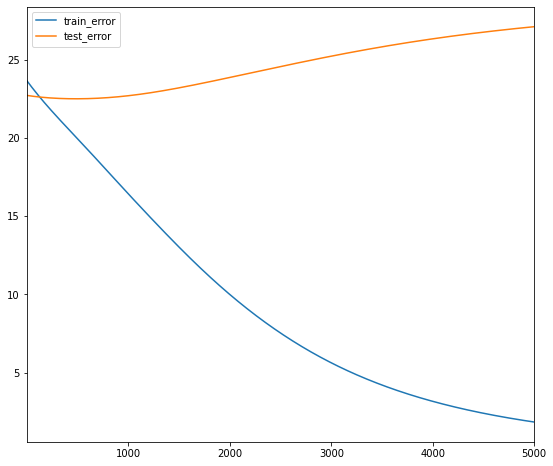

In [ ]:
model = build_model(rating_df, embedding_dim=30, init_stddev=0.5)
start= time.time()
model.train(num_iterations=5000, learning_rate=0.5)
end = time.time()
print('time cost',end-start,'s')

In [18]:
import numpy as np

In [19]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

In [20]:
item_set=rating_df['aid'].map(lambda x : dict_items[x]).unique()

In [21]:
item_set = item_set.tolist()

In [22]:

def user_recommendations(model, measure=DOT, exclude_rated=False, k=6):
  scores = compute_scores(
        model.embeddings["user_id"][2301], model.embeddings["item_id"], measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'aid': item_set
  })
  if exclude_rated:
    rated_items = rating_df[rating_df.session == "2301"]["aid"].values
    df = df[df.aid.apply(lambda aid: aid not in rated_items)]
  display.display(df.sort_values([score_key], ascending=False).head(k))  

In [23]:
from IPython import display

In [ ]:
user_recommendations(model, measure=COSINE, k=5)

,cosine score,aid
73112,0.704997,586945
63531,0.684051,1088873
48145,0.661742,1482108
37404,0.641064,1821829
7605,0.623335,253268


In [ ]:
user_recommendations(model, measure=DOT, k=5)

,dot score,aid
6028,13.236178,1293949
9388,12.609770,1647563
8573,9.564992,1378087
43551,9.257178,393073
73112,8.300262,586945


In [24]:
def item_neighbors(model, item_aid, measure=DOT, k=6):
  id=dict_items_to_index[item_aid]
  scores = compute_scores(
      model.embeddings["item_id"][id], model.embeddings["item_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'aid': item_set,
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

In [25]:
last_aid=item_set[10]
last_aid

154930

In [ ]:
item_neighbors(model, last_aid, DOT)
item_neighbors(model, last_aid, COSINE)

,dot score,aid
26039,8.092097,1796601
4997,7.489398,148534
10,7.182528,154930
23569,5.836050,835010
15752,5.671343,372708
62833,5.510988,274014


,cosine score,aid
10,1.000000,154930
55976,0.682462,1279732
19832,0.639524,5108
62067,0.631948,620136
55309,0.607958,1311153
54070,0.606172,314393


In [26]:

def gravity(U, V):
  return 1. / (U.shape[0]*V.shape[0]) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

def build_regularized_model(
    ratings, embedding_dim=3, regularization_coeff=.1, gravity_coeff=1.,
    init_stddev=0.1):
  train_ratings, test_ratings = split_dataframe(ratings)
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random.normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random.normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

  error_train = sparse_mean_square_error(A_train, U, V)
  error_test = sparse_mean_square_error(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U*U)/U.shape[0] + tf.reduce_sum(V*V)/V.shape[0])
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_error_observed': error_train,
      'test_error_observed': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"user_id": U, "item_id": V}

  return CFModel(embeddings, total_loss, [losses, loss_components])

 iteration 2000: train_error_observed=0.110603, test_error_observed=19.974016, observed_loss=0.110603, regularization_loss=0.791960, gravity_loss=0.311764
time cost 3146.758059501648 s


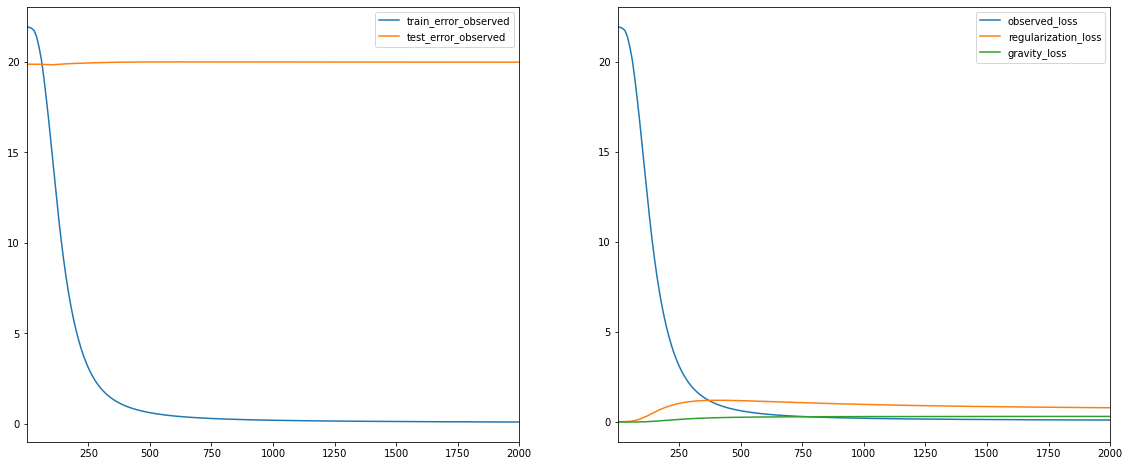

In [ ]:
reg_model = build_regularized_model(
    rating_df, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35,
    init_stddev=.05)
start = time.time()
reg_model.train(num_iterations=2000, learning_rate=20.)
end = time.time()
print('\ntime cost',end-start,'s')

 iteration 2000: train_error_observed=0.207830, test_error_observed=20.202364, observed_loss=0.207830, regularization_loss=0.974009, gravity_loss=0.301181<tf.Variable 'Variable_34:0' shape=(2302, 35) dtype=float32>
<tf.Variable 'Variable_35:0' shape=(73139, 35) dtype=float32>

time cost 3178.584616422653 s


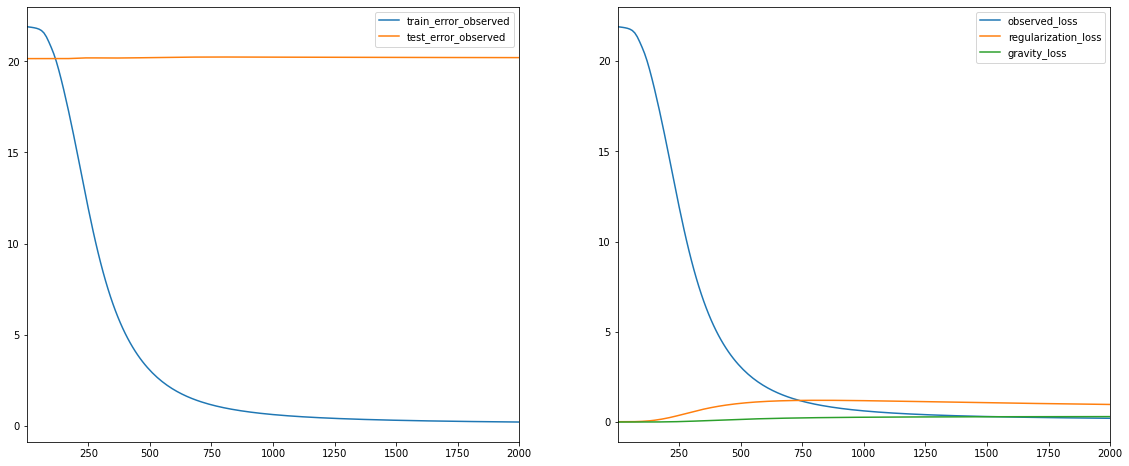

In [103]:
reg_model = build_regularized_model(
    rating_df, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35,
    init_stddev=.05)
start = time.time()
reg_model.train(num_iterations=2000, learning_rate=10.)
end = time.time()
print('\ntime cost',end-start,'s')

In [33]:
user_recommendations(reg_model, DOT, exclude_rated=True, k=10)

,dot score,aid
60890,6.356245,1429651
48306,4.501638,305820
15343,3.712597,1472383
15332,3.636225,1262120
54135,3.546209,546944
60857,3.407021,622384
13526,3.335998,448507
54161,2.935899,1589169
13568,2.893371,1218351
13541,2.785946,675885


In [34]:
item_neighbors(reg_model, last_aid, DOT)
item_neighbors(reg_model, last_aid, COSINE)

,dot score,aid
25762,0.988194,1156034
51838,0.967218,1057154
41020,0.832230,1014973
60890,0.810792,1429651
39901,0.717302,884244
11100,0.697249,610409


,cosine score,aid
10,1.000000,154930
37759,0.561051,120657
65412,0.536725,607672
52404,0.524874,925314
25526,0.521534,1217806
17652,0.519688,1841605


In [81]:
def make_batch(ratings, batch_size):
  def pad(x, fill):
    return pd.DataFrame.from_dict(x).fillna(fill).values
  label = []
  for item_ids in item_set:
    label.append([int(item_id) for item_id in str(item_ids)])
  features = {
      "item_id": pad(index, ""),
      "label": pad(label, -1)
  }
  batch = (
      tf.compat.v1.data.Dataset.from_tensor_slices(features)
      .shuffle(1000)
      .repeat()
      .batch(batch_size)
      .make_one_shot_iterator()
      .get_next())
  return batch

def select_random(x):
  def to_float(x):
    return tf.cast(x, tf.float32)
  def to_int(x):
    return tf.cast(x, tf.int64)
  batch_size = tf.shape(x)[0]
  rn = tf.range(batch_size)
  nnz = to_float(tf.compat.v1.count_nonzero(x >= 0, axis=1))
  rnd = tf.compat.v1.random_uniform([batch_size])
  ids = tf.stack([to_int(rn), to_int(nnz * rnd)], axis=1)
  return to_int(tf.gather_nd(x, ids))

In [107]:
def softmax_loss(user_embeddings, item_embeddings, labels):
  user_emb_dim = user_embeddings.shape[1]
  item_emb_dim = item_embeddings.shape[1]
  if user_emb_dim != item_emb_dim:
    raise ValueError(
        "The user embedding dimension %d should match the movie embedding "
        "dimension % d" % (user_emb_dim, item_emb_dim))

  logits = tf.compat.v1.matmul(user_embeddings, item_embeddings, transpose_b=True)
  loss = tf.compat.v1.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
      logits=logits, labels=labels))
  return loss

In [124]:
def build_softmax_model(rated_items, embedding_cols, hidden_dims):

  def create_network(features):
    inputs = tf.compat.v1.feature_column.input_layer(features, embedding_cols)
    input_dim = inputs.shape[1]
    for i, output_dim in enumerate(hidden_dims):
      w = tf.compat.v1.get_variable(
          "hidden%d_w_" % i, shape=[input_dim, output_dim],
          initializer=tf.compat.v1.truncated_normal_initializer(
              stddev=1./np.sqrt(output_dim))) / 10.
      outputs = tf.compat.v1.matmul(inputs, w)
      input_dim = output_dim
      inputs = outputs
    return outputs

  train_rated_items, test_rated_items = split_dataframe(rated_items)
  train_batch = make_batch(train_rated_items, 200)
  test_batch = make_batch(test_rated_items, 100)

  with tf.compat.v1.variable_scope("model", reuse=False):
    # Train
    train_user_embeddings = create_network(train_batch)
    train_labels = select_random(train_batch["label"])
  with tf.compat.v1.variable_scope("model", reuse=tf.compat.v1.AUTO_REUSE):
    # Test
    test_user_embeddings = create_network(test_batch)
    test_labels = select_random(test_batch["label"])
    item_embeddings = tf.Variable(tf.random.normal(
      [73139, 35], stddev=0.5))
    

  test_loss = softmax_loss(
      test_user_embeddings, item_embeddings,test_labels)
  train_loss = softmax_loss(
      train_user_embeddings, item_embeddings,train_labels)
  _, test_precision_at_10 = tf.compat.v1.metrics.precision_at_k(
      labels=test_labels,
      predictions=tf.compat.v1.matmul(test_user_embeddings, item_embeddings, transpose_b=True),
      k=10)

  metrics = (
      {"train_loss": train_loss, "test_loss": test_loss},
      {"test_precision_at_10": test_precision_at_10}
  )
  embeddings = {"item_id": item_embeddings}
  return CFModel(embeddings, train_loss, metrics)

In [ ]:
rating_df=file[:100000:]

In [137]:
rated_items = (rating_df[["session", "aid"]]
                .groupby("session", as_index=False)
                .aggregate(lambda x: list(x)))
rated_items.head()

,session,aid
0,0,"[6851, 7563, 10268, 16246, 30373, 72748, 76358..."
1,1,"[50049, 105393, 109488, 207905, 215311, 376932..."
2,2,"[26638, 78519, 137492, 161269, 295985, 378348,..."
3,3,"[2512, 3999, 33731, 37450, 54857, 74985, 87629..."
4,4,"[255379, 298827, 383828, 479396, 613619, 67852..."


In [138]:
from array import array
res_array = array("i", index)

 iteration 5000: train_loss=2.197613, test_loss=2.194839, test_precision_at_10=0.079758<tf.Variable 'model_1/Variable:0' shape=(73139, 35) dtype=float32>


({'train_loss': 2.1976132, 'test_loss': 2.194839},
 {'test_precision_at_10': 0.07975824835032994})

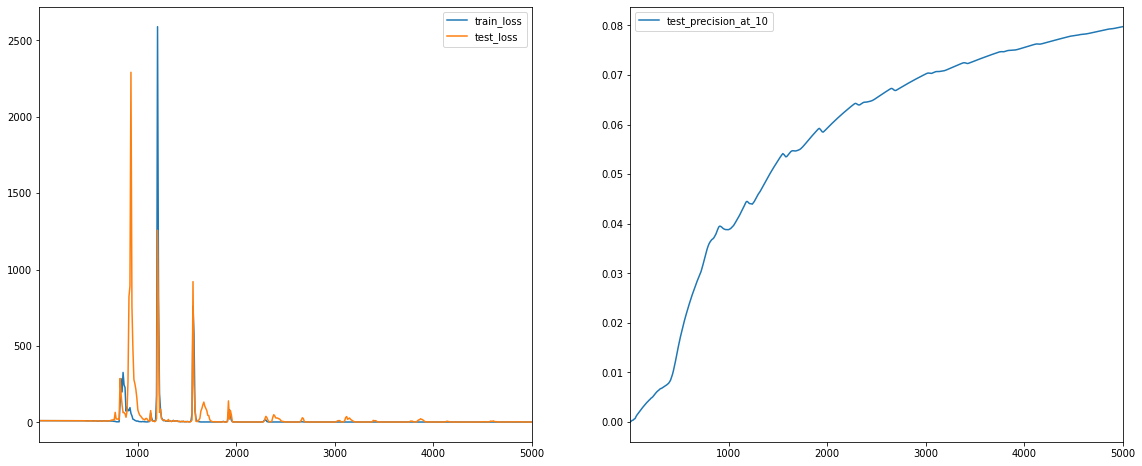

In [139]:
def make_embedding_col(key, embedding_dim):
  categorical_col = tf.feature_column.categorical_column_with_vocabulary_list(
      key=key, vocabulary_list=list(set(res_array)), num_oov_buckets=0)
  return tf.feature_column.embedding_column(
      categorical_column=categorical_col, dimension=embedding_dim,
      combiner='mean')

with tf.Graph().as_default():
  softmax_model = build_softmax_model(
      rated_items,
      embedding_cols=[
          make_embedding_col("item_id", 35),
      ],
      hidden_dims=[35])

softmax_model.train(
    learning_rate=8., num_iterations=5000, optimizer=tf.compat.v1.train.AdagradOptimizer)

 iteration 7000: train_loss=1.975195, test_loss=15.215503, test_precision_at_10=0.086817<tf.Variable 'model_1/Variable:0' shape=(73139, 35) dtype=float32>


({'train_loss': 1.975195, 'test_loss': 15.215503},
 {'test_precision_at_10': 0.08681688330238538})

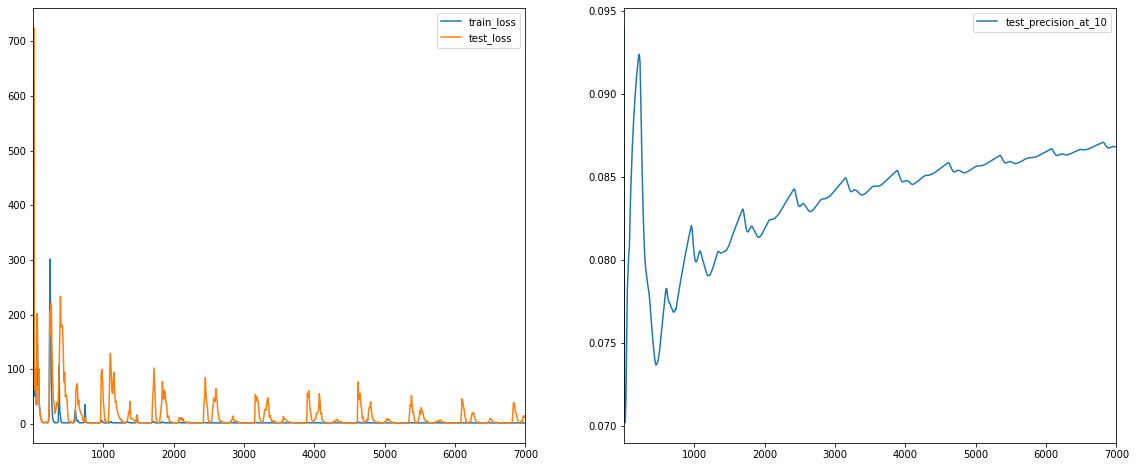

In [127]:
softmax_model.train(
    learning_rate=6., num_iterations=7000, optimizer=tf.compat.v1.train.AdagradOptimizer)

In [140]:
item_neighbors(softmax_model, last_aid, DOT)
item_neighbors(softmax_model, last_aid, COSINE)

,dot score,aid
67022,12.063107,493809
26065,7.876256,1433782
10,6.751487,154930
66960,6.741938,1628538
23460,6.533100,1592068
44612,6.011663,1812752


,cosine score,aid
10,1.000000,154930
25519,0.646426,989211
44612,0.638951,1812752
63321,0.626361,1688097
12309,0.610358,783644
559,0.598580,1397980
